In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import calmap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.simplefilter('ignore')

In [3]:
os.chdir("..")

In [4]:
if not os.path.isdir("predictions/graphs"):
    os.mkdir("predictions/graphs")

In [5]:
data = pd.read_excel("raw_data/Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

In [6]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

In [7]:
data.dtypes

Дата                                                      datetime64[ns]
Выработка электроэнергии ТА гр.130                               float64
Отпуск тепла из ТО ТА гр.130                                     float64
Удельный расход условного топлива на отпуск э/э гр.130           float64
Unnamed: 4                                                       float64
Предсказание полином 2                                           float64
0.033374592702317095                                             float64
dtype: object

In [8]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [9]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

In [10]:
def get_columns_without_targets(target_column: str):
    return list(set(columns_for_predictions) - {target_column})

<Figure size 2000x1600 with 0 Axes>

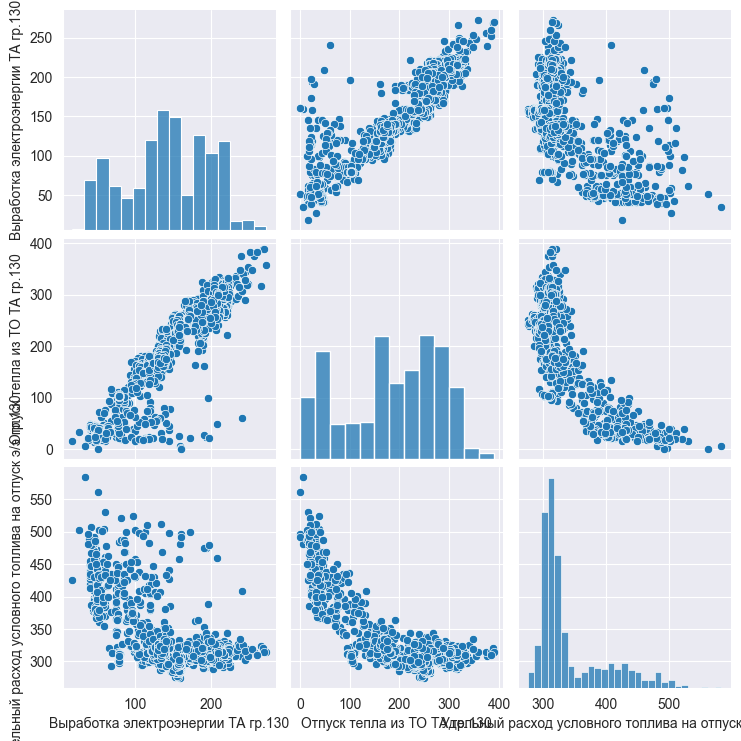

In [11]:
plt.figure(figsize=(10,8), dpi=200)
sns.pairplot(data[columns_for_predictions])
plt.show()

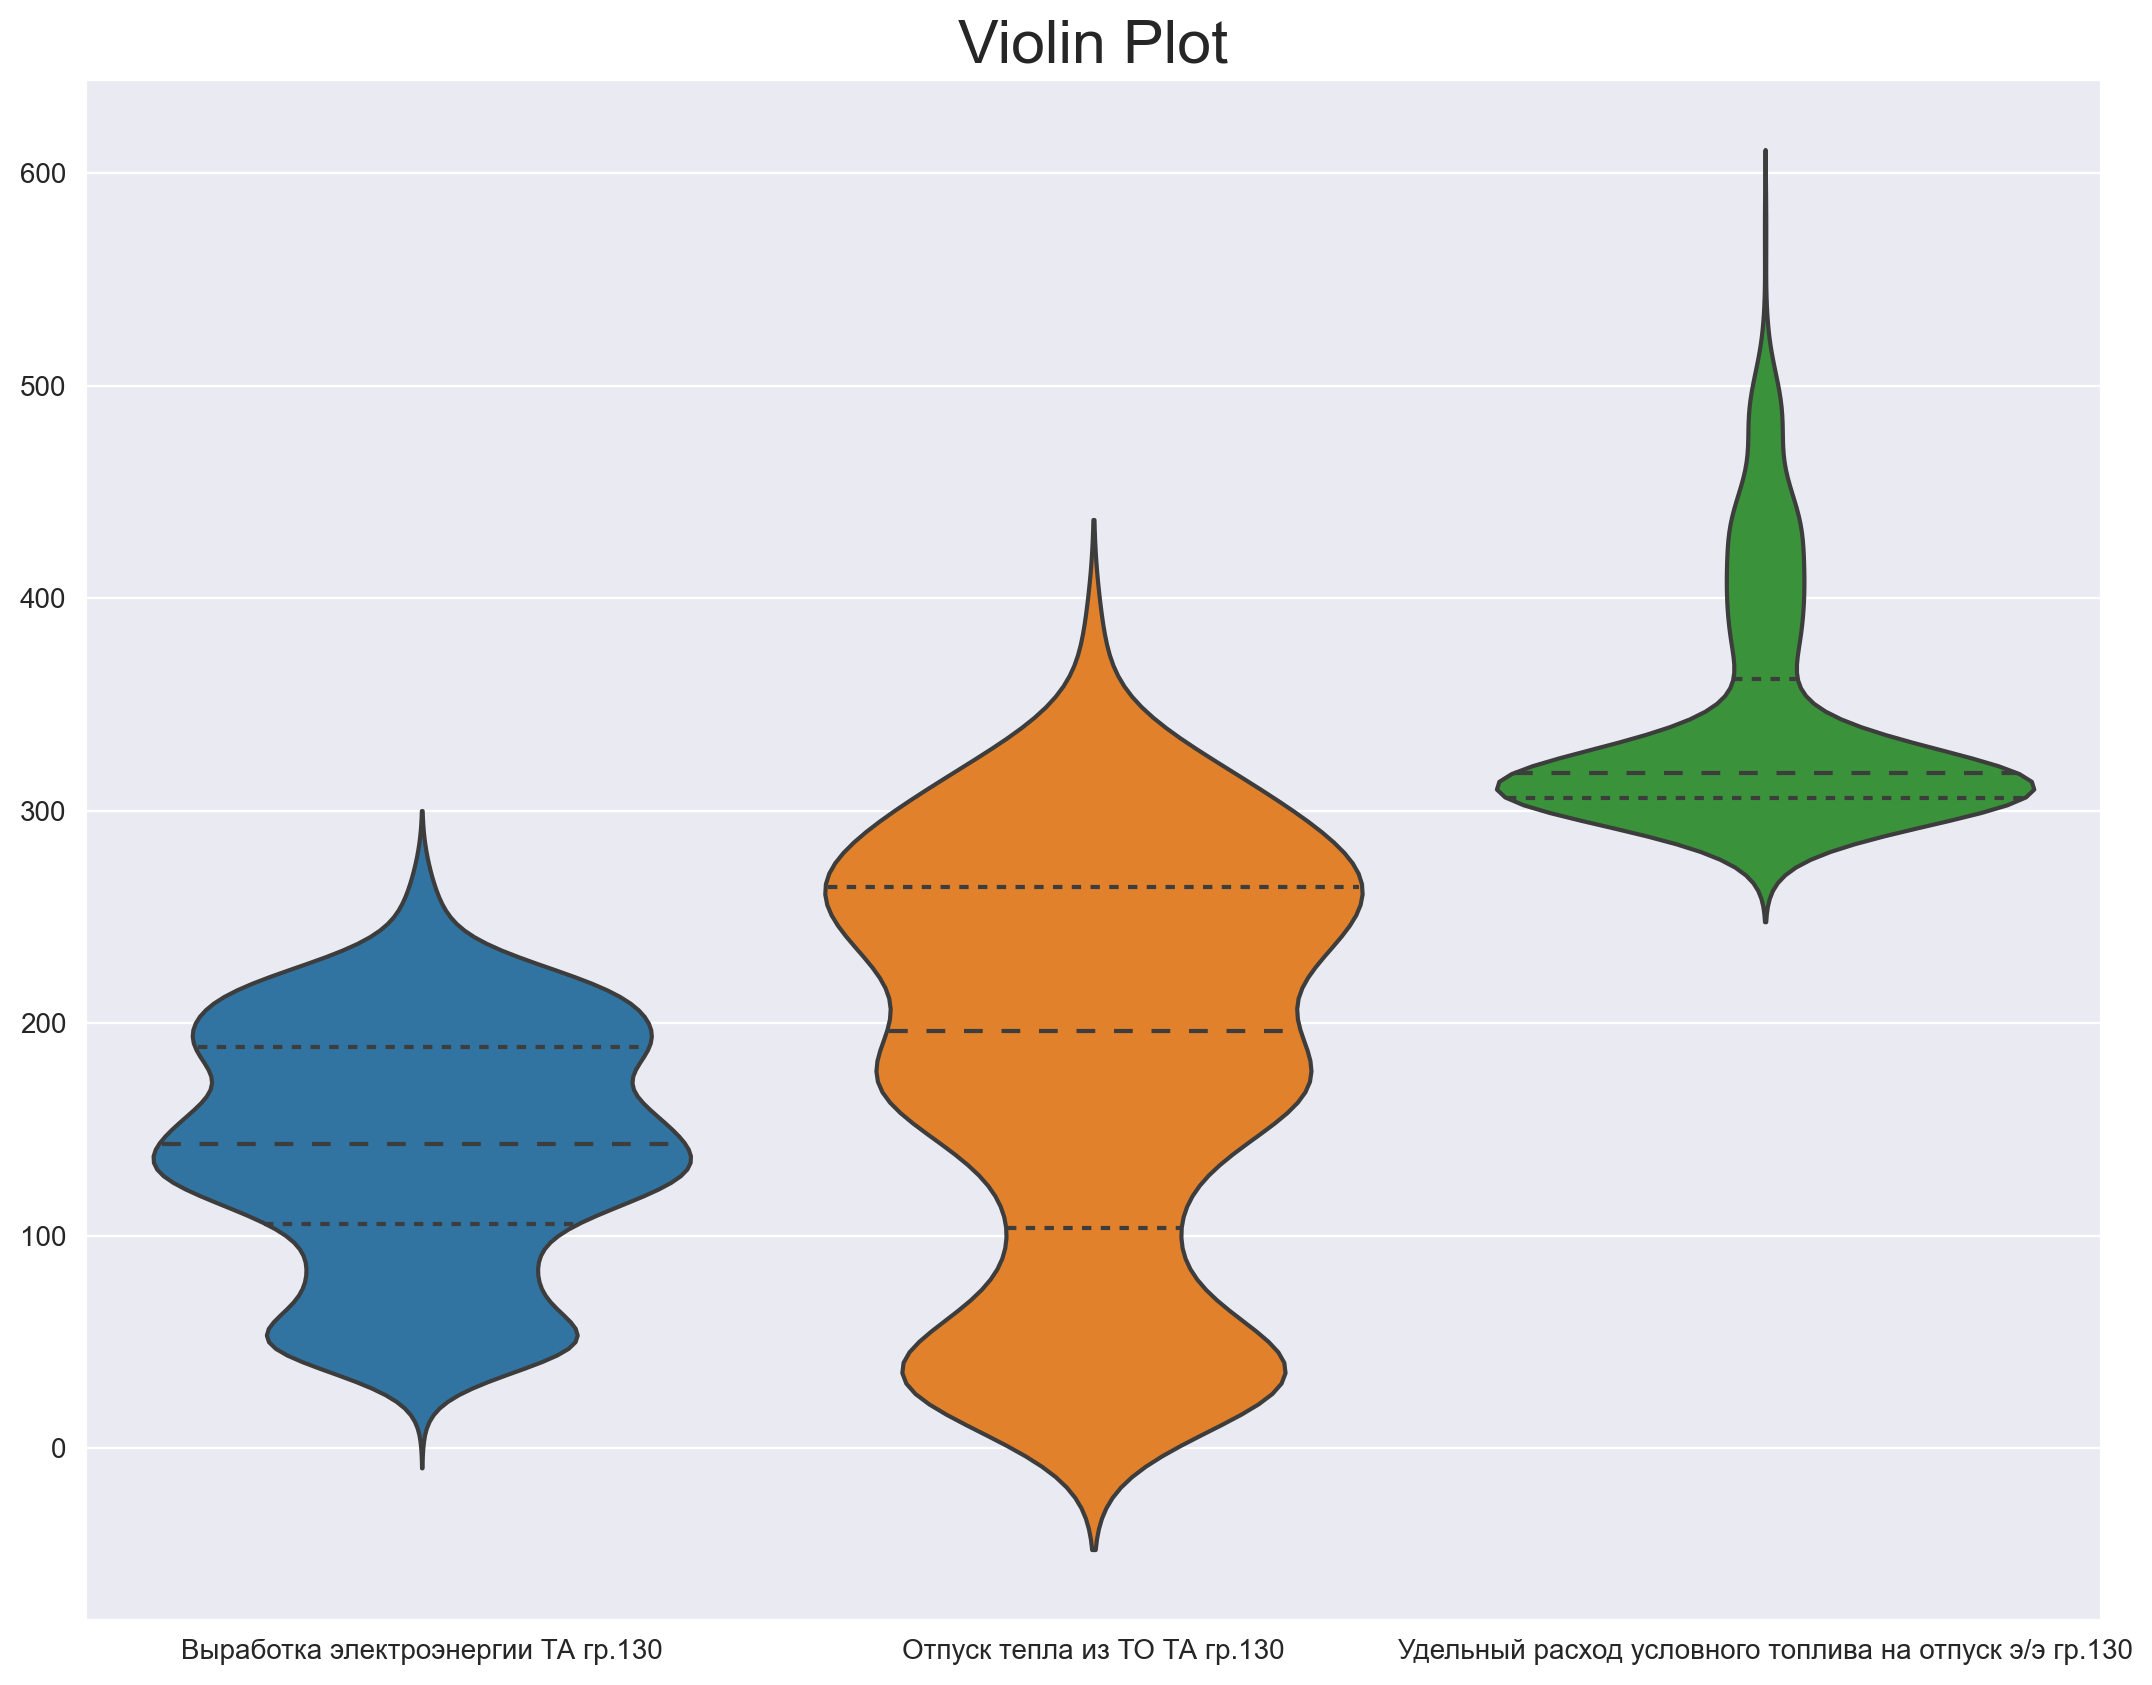

In [12]:
plt.figure(figsize=(13,10), dpi=200)
sns.violinplot(data=data[columns_for_predictions], scale='width', inner='quartile')

# Decoration
plt.title('Violin Plot', fontsize=22)
plt.show()

In [13]:
data = data.rename(columns={"Дата": "date"})

In [14]:
data = data.set_index("date")

<Figure size 3200x2000 with 0 Axes>

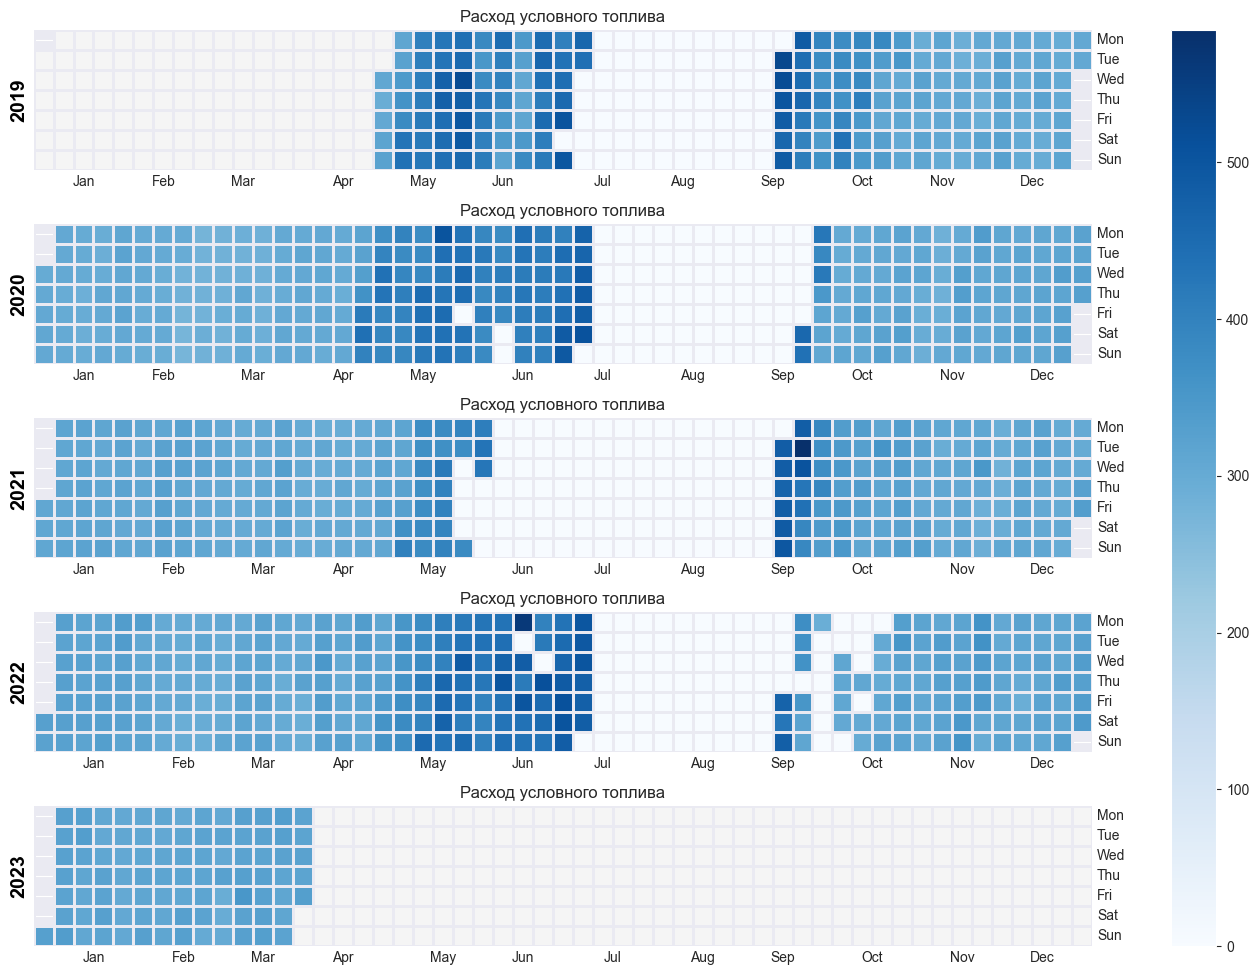

In [15]:
plt.figure(figsize=(16,10), dpi=200)
fig, ax = calmap.calendarplot(
    data[target],
    fig_kws={'figsize': (16,10)},
    yearlabel_kws={'color':'black', 'fontsize':14},
    cmap="Blues", subplot_kws={'title':'Расход условного топлива'}
)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
plt.savefig("predictions/graphs/calendarplot.png")
plt.savefig("predictions/graphs/calendarplot.svg")
plt.show()

In [16]:
data.reset_index(inplace=True)

In [17]:
data["year"] = [i.year for i in data.date]

In [18]:
data.groupby("year").mean()[target].values

array([367.50013383, 338.08198975, 328.66421247, 348.16474174,
       318.03051842])

<BarContainer object of 5 artists>

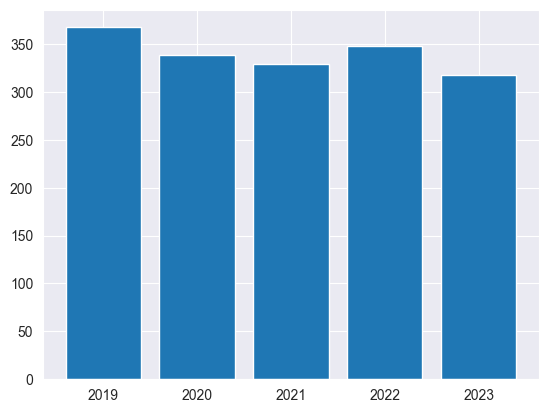

In [19]:
plt.bar(x=data.year.unique(), height=data.groupby("year").mean()[target])

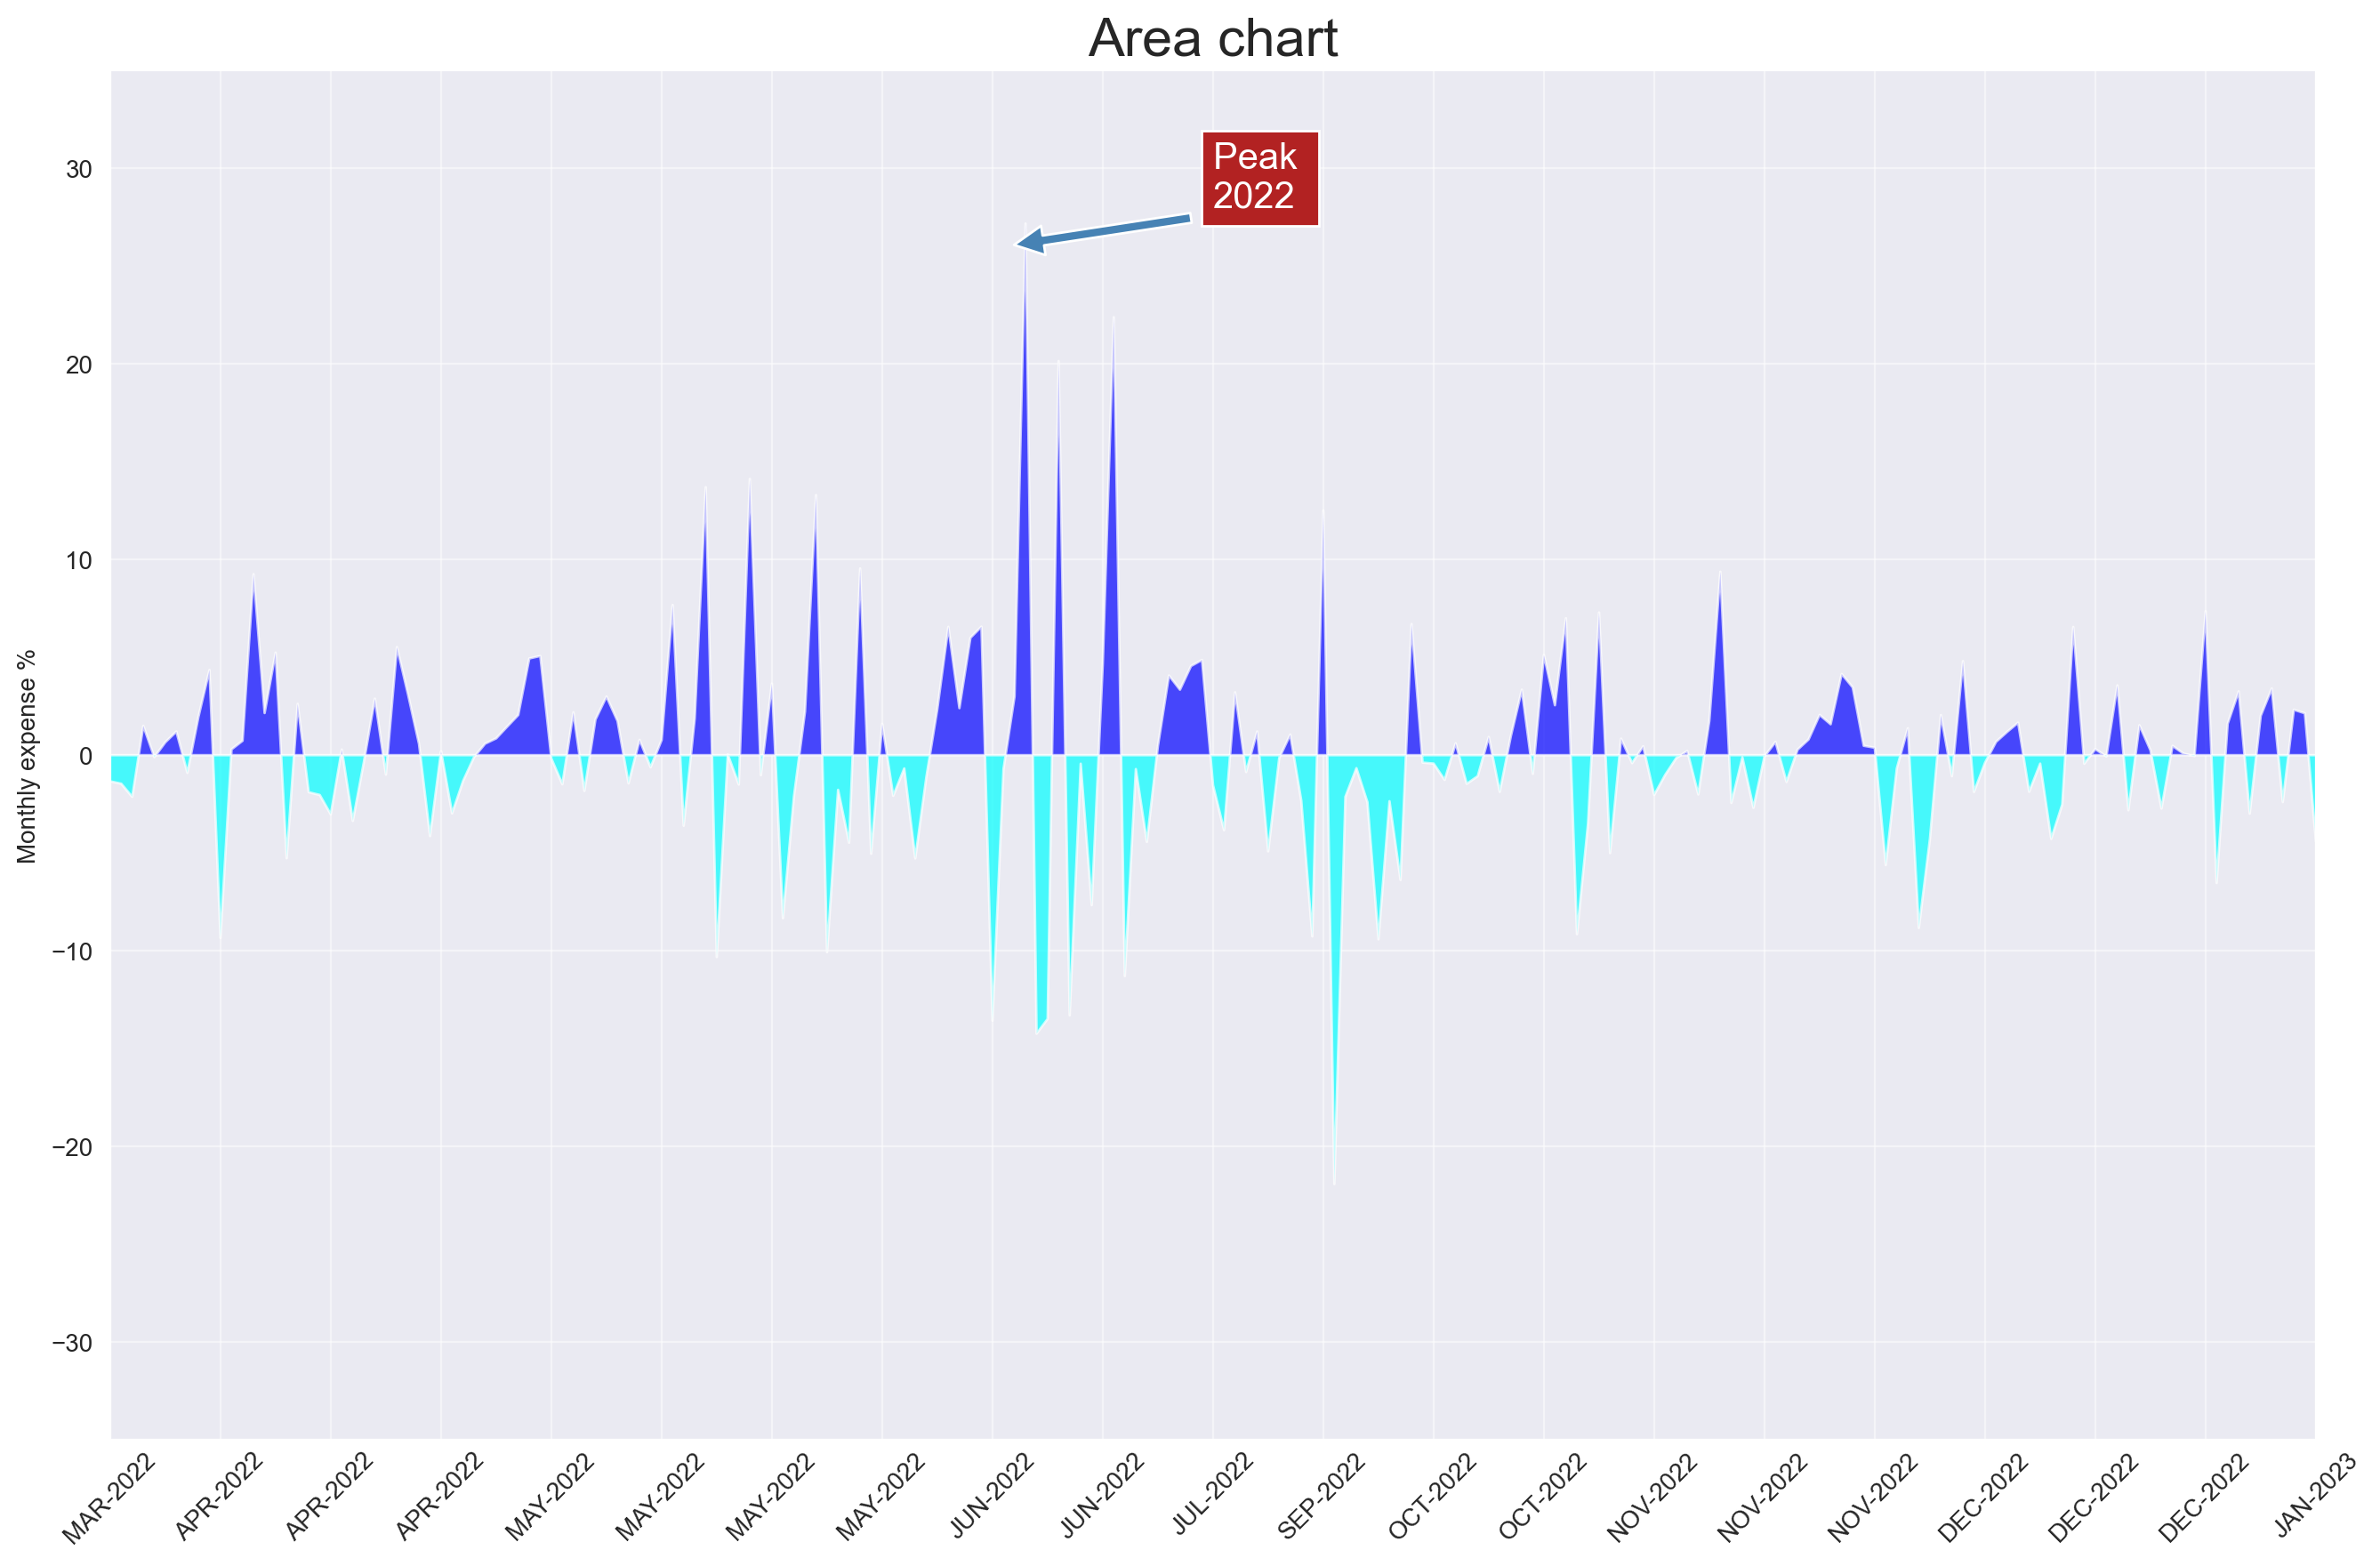

In [20]:
x = np.arange(data.shape[0])
y_returns = (data[target].diff().fillna(0) / data[target].shift(1)).fillna(0) * 100

plt.figure(figsize=(16,10), dpi=200)
plt.fill_between(
    x[1:], y_returns[1:], where=y_returns[1:] >= 0,
    facecolor='blue', interpolate=True, alpha=0.7,
)
plt.fill_between(
    x[1:], y_returns[1:], where=y_returns[1:] <= 0,
    facecolor='aqua', interpolate=True, alpha=0.7,
)

plt.annotate('Peak \n2022', xy=(881.0, 26.0), xytext=(900.0, 28),
             bbox=dict(boxstyle='square', fc='firebrick'),
             arrowprops=dict(facecolor='steelblue', shrink=0.05), fontsize=15, color='white')


xtickvals = [
    str(m)[:3].upper() + "-" + str(y)
    for y, m in zip(data.date.dt.year, data.date.dt.month_name())
]
plt.gca().set_xticks(x[::10])
plt.gca().set_xticklabels(xtickvals[::10], rotation=45, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})
plt.ylim(-35,35)
plt.xlim(800,1000)
plt.title("Area chart", fontsize=22)
plt.ylabel('Monthly expense %')
plt.grid(alpha=0.5)
plt.savefig("predictions/graphs/areachart.png")
plt.savefig("predictions/graphs/areachart.svg")
plt.show()

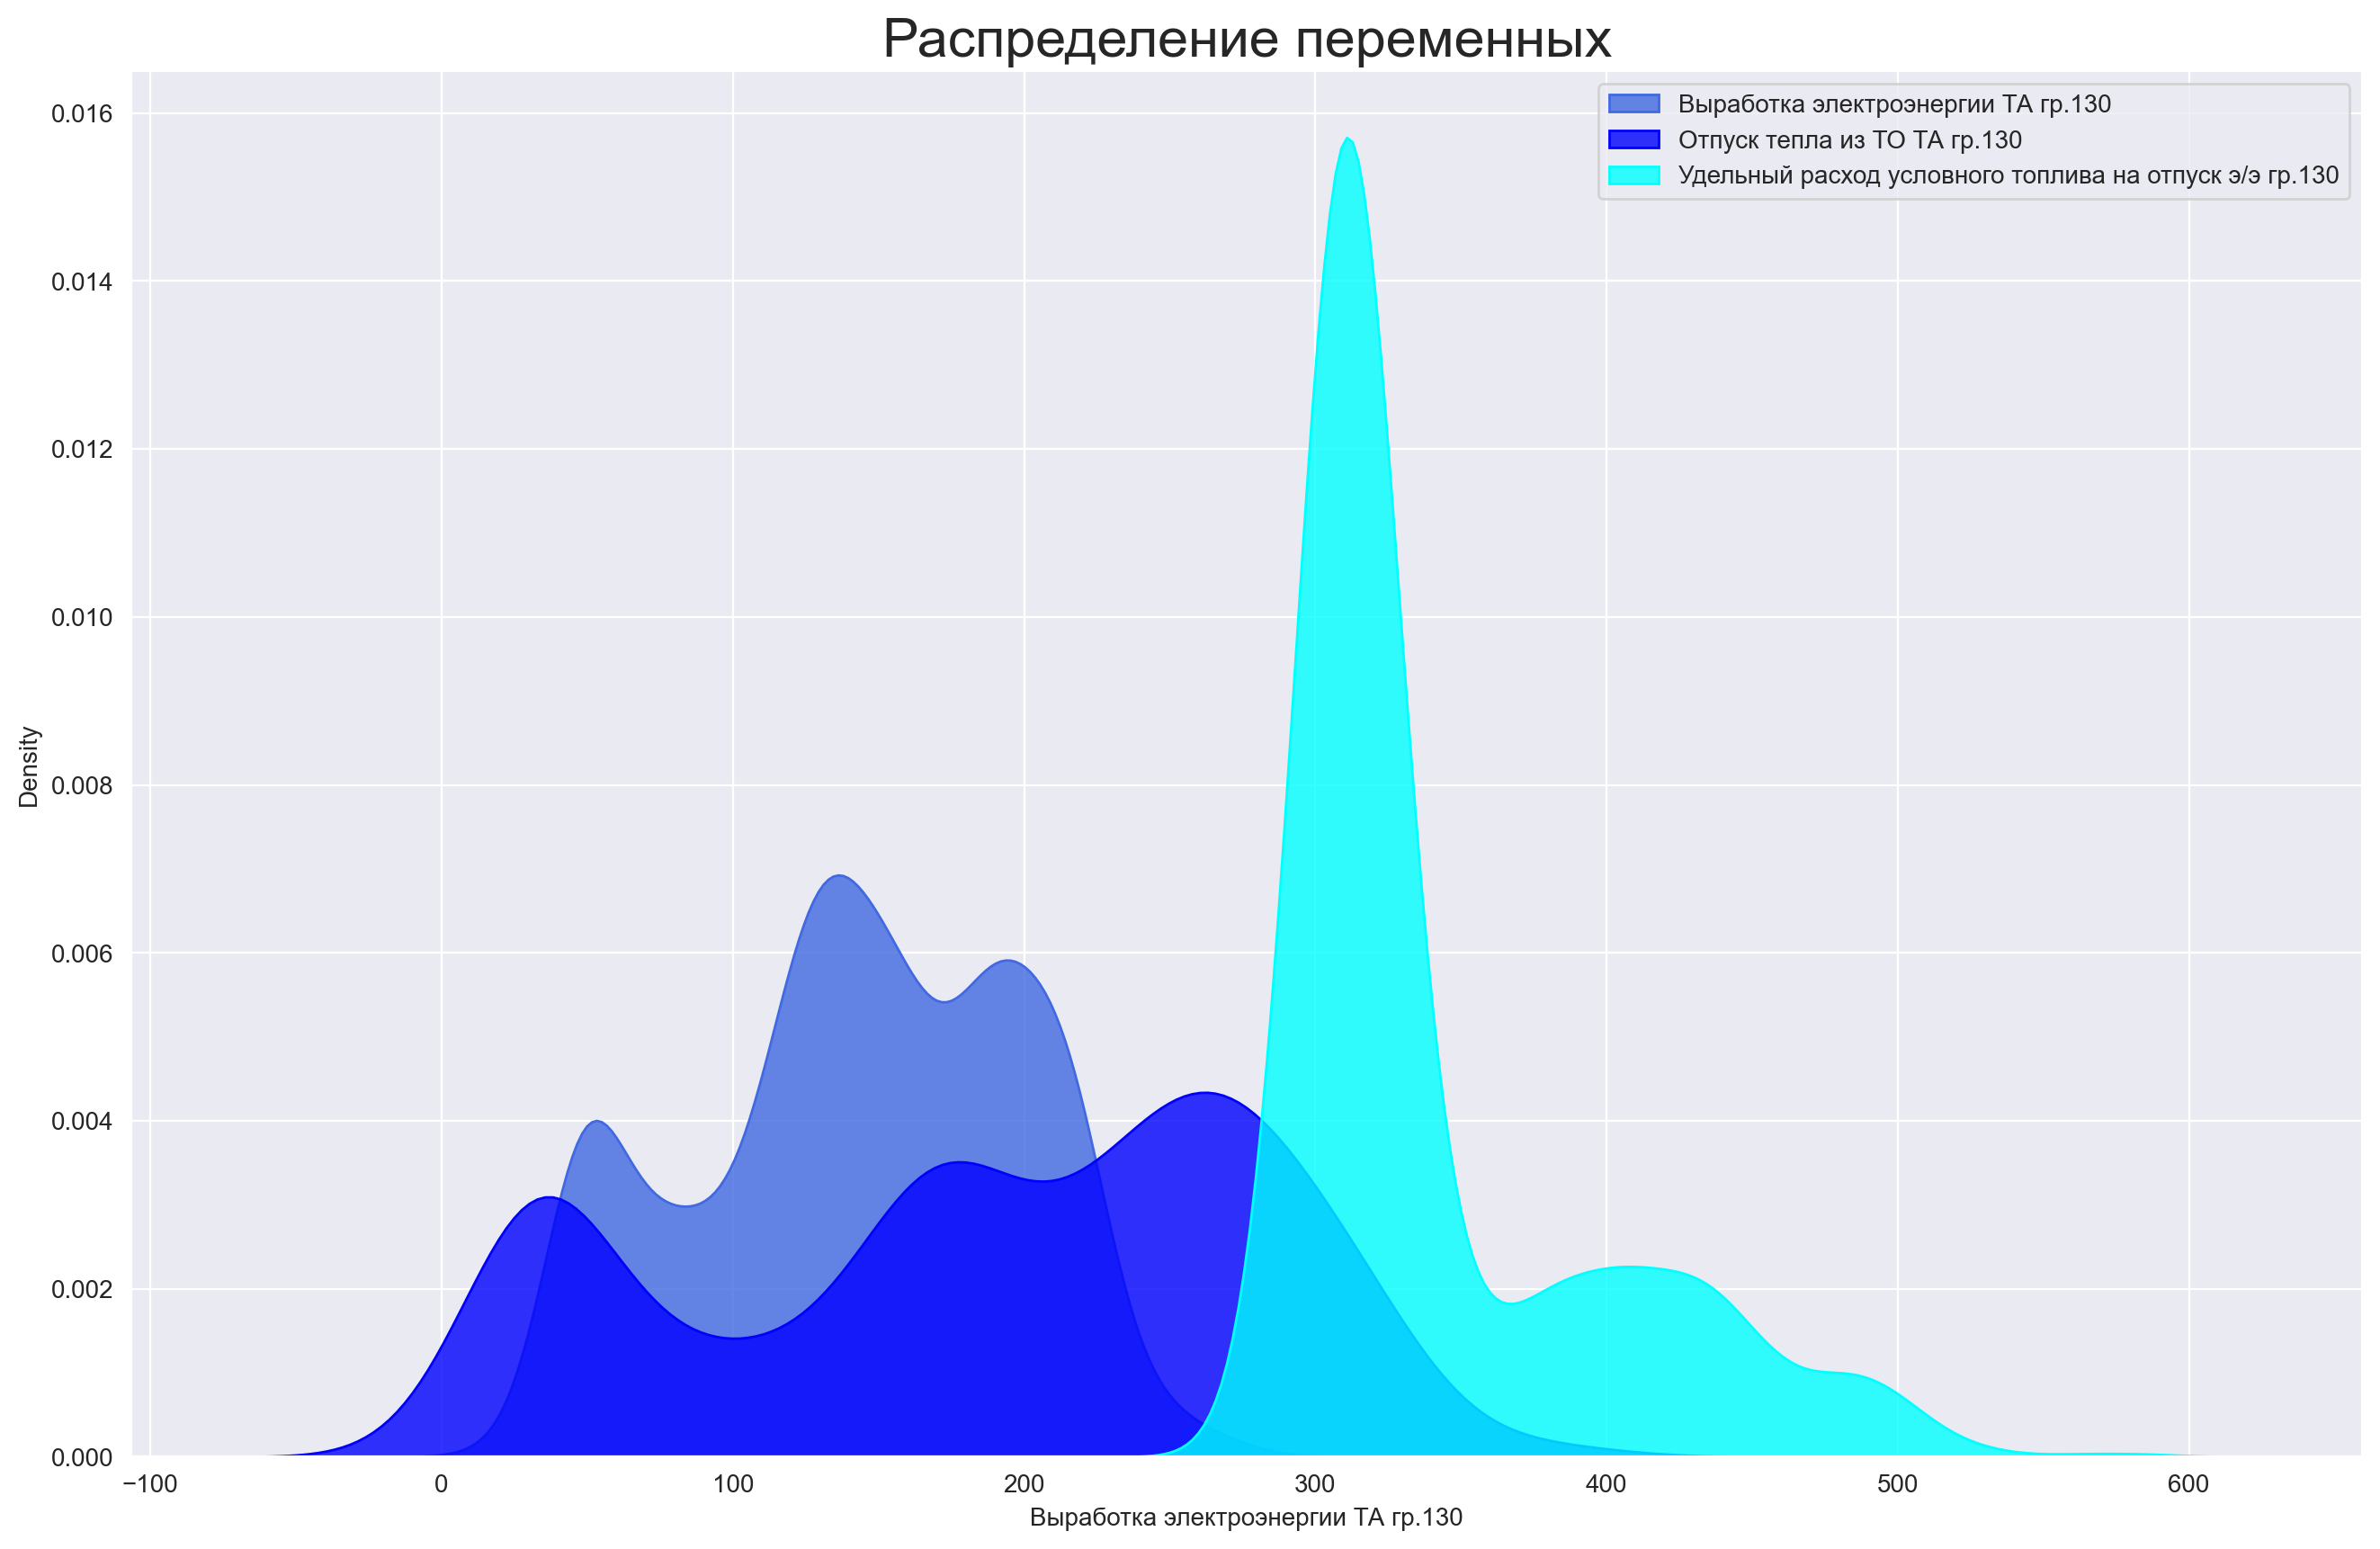

In [21]:
plt.figure(figsize=(16, 10), dpi=200)
sns.kdeplot(
    data[columns_for_predictions[0]], shade=True, color="royalblue", label=columns_for_predictions[0], alpha=.8
)
sns.kdeplot(
    data[columns_for_predictions[1]], shade=True, color="blue",
    label=columns_for_predictions[1], alpha=.8
)
sns.kdeplot(
    data[columns_for_predictions[2]], shade=True, color="aqua",
    label=columns_for_predictions[2], alpha=.8
)
plt.title('Распределение переменных', fontsize=22)
plt.legend()
plt.savefig("predictions/graphs/kdeplot.png")
plt.savefig("predictions/graphs/kdeplot.svg")
plt.show()

In [26]:
data_out = pd.read_csv("raw_data/out.csv")

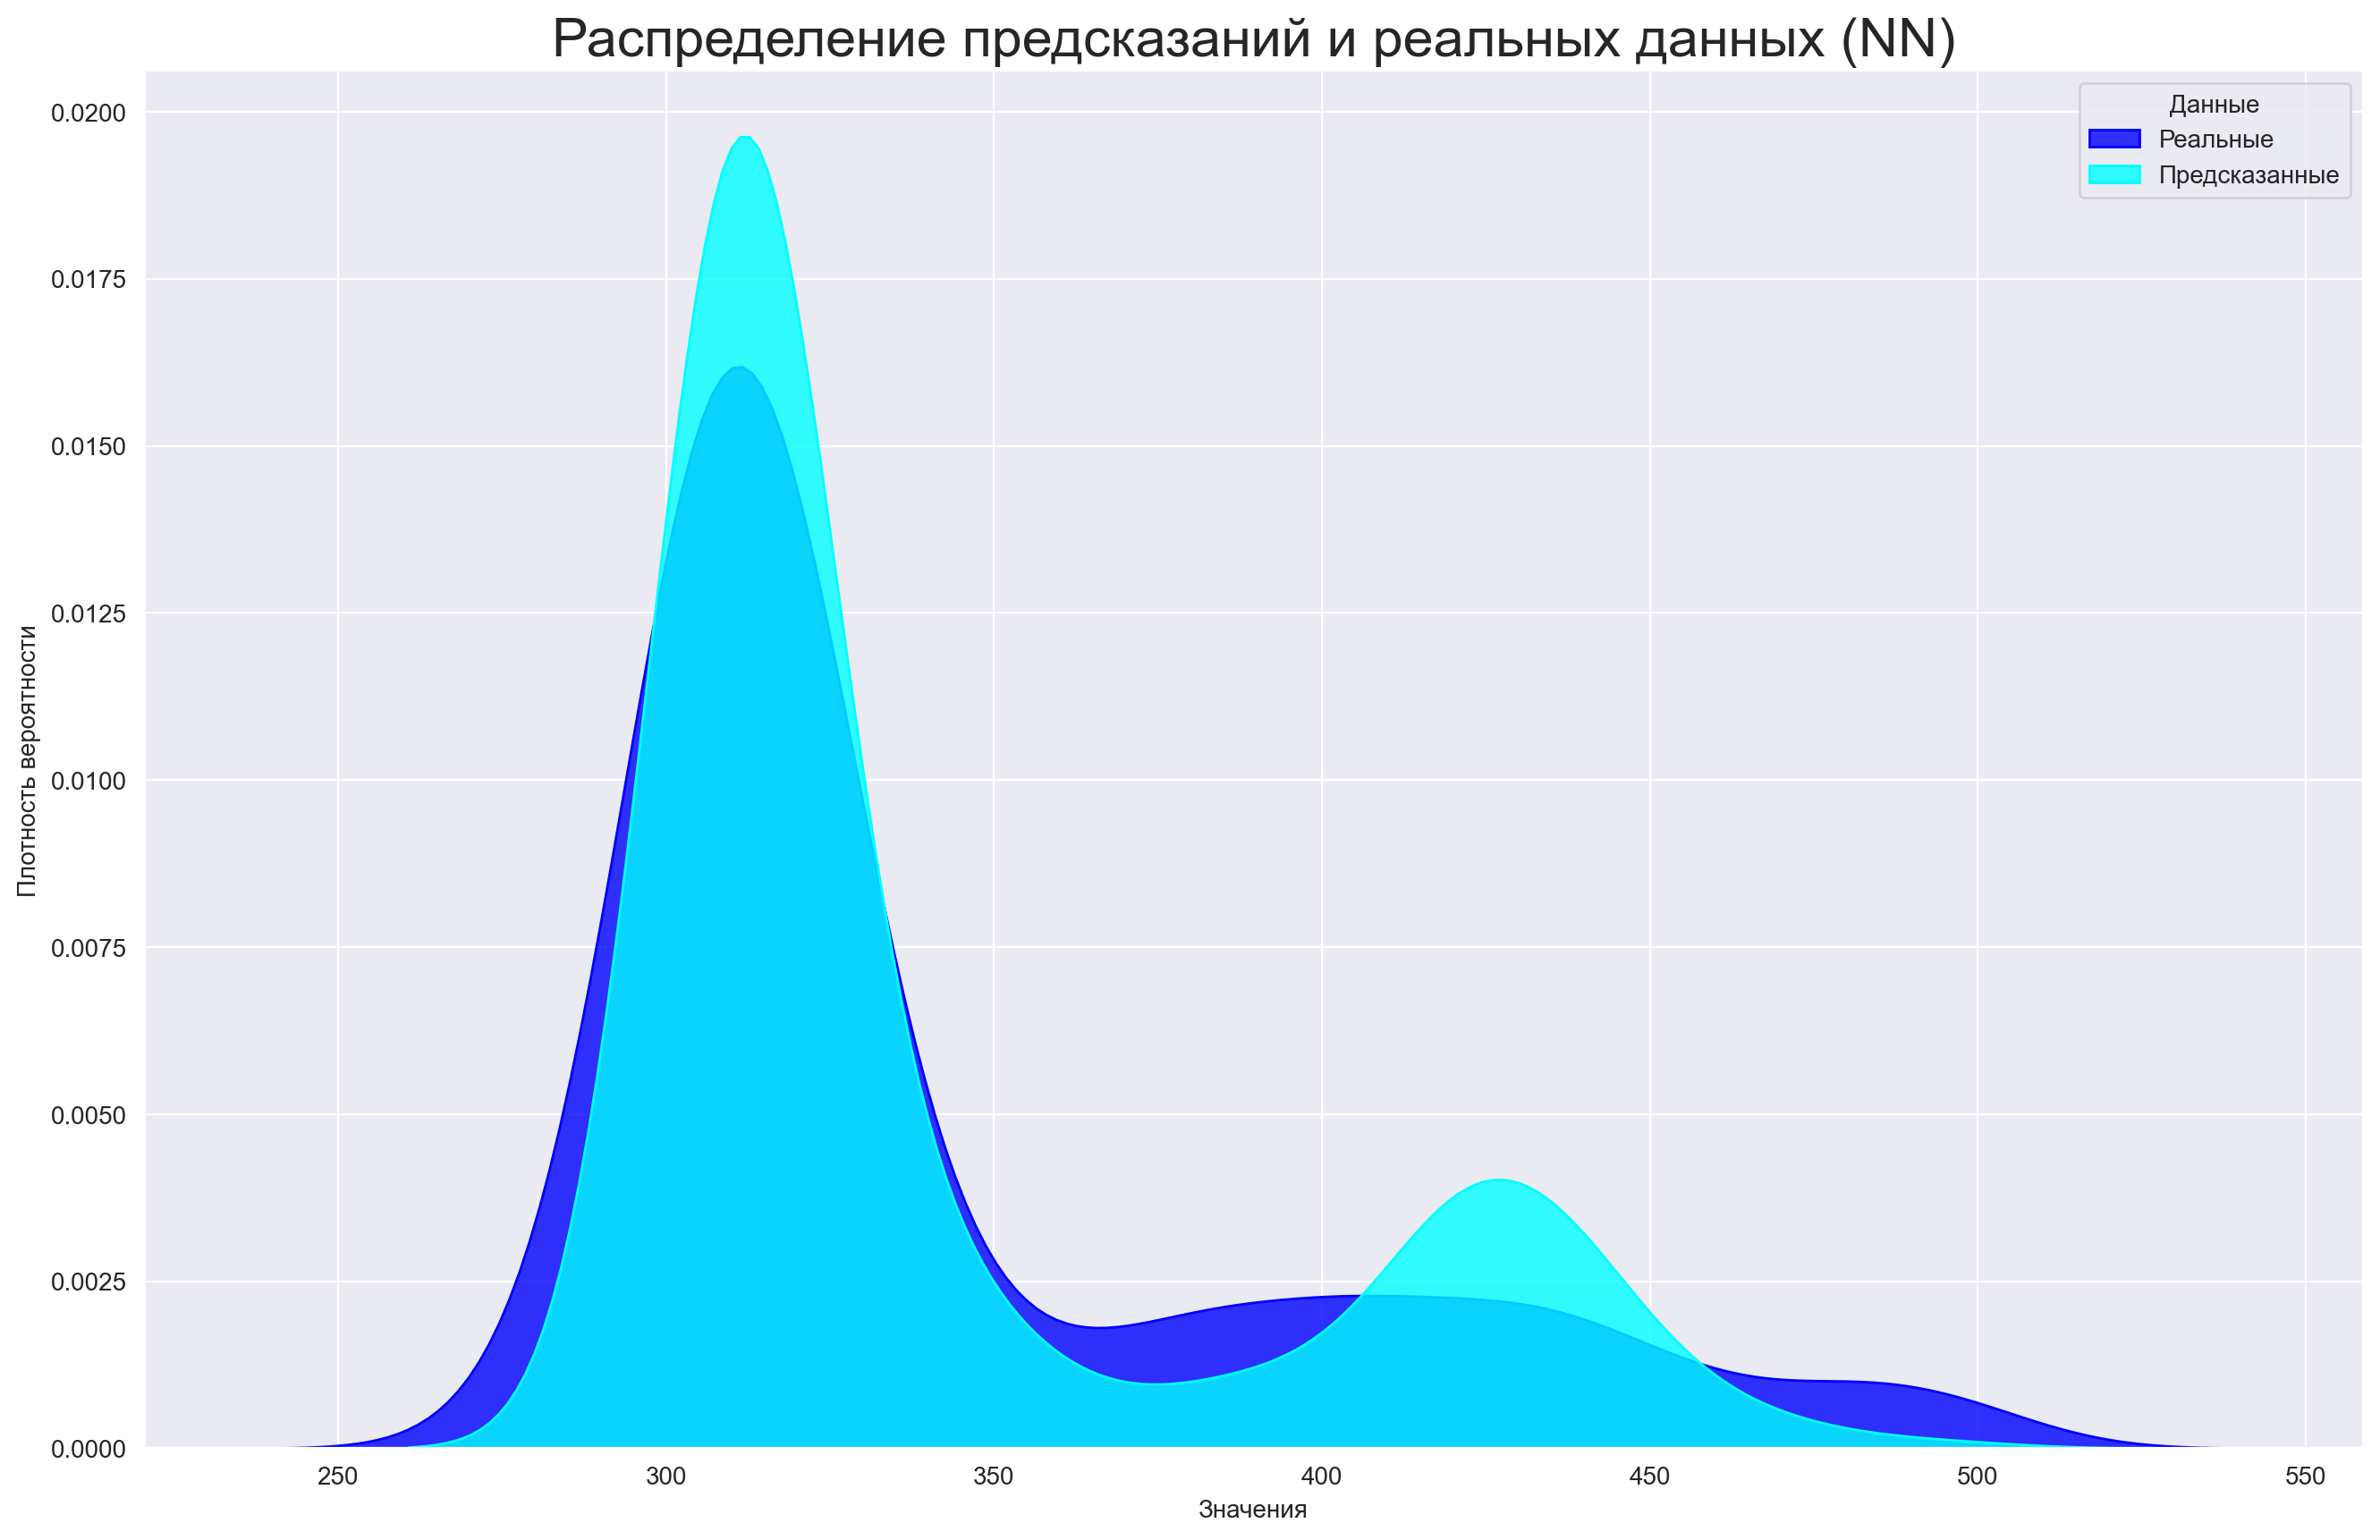

In [36]:
plt.figure(figsize=(16, 10), dpi=200)
sns.kdeplot(
    data_out.real, shade=True, color="blue", label="Реальные", alpha=.8
)
sns.kdeplot(
    data_out.pred, shade=True, color="aqua",
    label="Предсказанные", alpha=.8
)
plt.title('Распределение предсказаний и реальных данных (NN)', fontsize=22)
plt.xlabel("Значения")
plt.ylabel("Плотность вероятности")
plt.legend(title="Данные")
plt.savefig("predictions/graphs/nn_kdeplot.png")
plt.savefig("predictions/graphs/nn_kdeplot.svg")
plt.show()